In [35]:
%matplotlib inline
import os,random
import numpy as np
import theano as th
import pandas as pd
import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers import Input,merge
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten,MaxoutDense
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import *
from keras.layers.wrappers import TimeDistributed
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, UpSampling2D
from keras.layers.recurrent import LSTM
from keras.regularizers import *
from keras.layers.normalization import *
from keras.optimizers import *
import matplotlib.pyplot as plt
import seaborn as sns
import cPickle, random, sys, keras
from keras.models import Model
from IPython import display
from keras.utils import np_utils
from tqdm import tqdm

In [61]:
ds = pd.read_csv('../datasets/mnist_data/train.csv')
data = ds.values

print data.shape

(42000, 785)


In [63]:
split = int(32000)

X_train = data[:split, 1:]
X_test = data[split:, 1:]

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print np.min(X_train), np.max(X_train)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

0.0 1.0
('X_train shape:', (32000, 1, 28, 28))
(32000, 'train samples')
(10000, 'test samples')


In [48]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [52]:
shp = X_train.shape[1:]
dropout_rate = 0.25
opt = Adam(lr=1e-4)
dopt = Adam(lr=1e-3)

# Build Generative model ...
nch = 200
g_input = Input(shape=[100])
H = Dense(nch*14*14, init='glorot_normal')(g_input)
H = BatchNormalization(mode=2)(H)
H = Activation('relu')(H)
H = Reshape( [nch, 14, 14] )(H)
H = UpSampling2D((2,2),dim_ordering='th')(H)
H = Convolution2D(nch/2, 3, 3, border_mode='same', init='glorot_uniform',dim_ordering='th')(H)
H = BatchNormalization(mode=2)(H)
H = Activation('relu')(H)
H = Convolution2D(nch/4, 3, 3, border_mode='same', init='glorot_uniform',dim_ordering='th')(H)
H = BatchNormalization(mode=2)(H)
H = Activation('relu')(H)
H = Convolution2D(1, 1, 1, border_mode='same', init='glorot_uniform',dim_ordering='th')(H)
g_V = Activation('sigmoid')(H)
generator = Model(g_input,g_V)
generator.compile(loss='binary_crossentropy', optimizer=opt)
generator.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_25 (InputLayer)            (None, 100)           0                                            
____________________________________________________________________________________________________
dense_24 (Dense)                 (None, 39200)         3959200     input_25[0][0]                   
____________________________________________________________________________________________________
batchnormalization_54 (BatchNorm (None, 39200)         156800      dense_24[0][0]                   
____________________________________________________________________________________________________
activation_70 (Activation)       (None, 39200)         0           batchnormalization_54[0][0]      
___________________________________________________________________________________________

In [31]:
UpSampling2D?

In [54]:
# Build Discriminative model ...
d_input = Input(shape=shp)
H = Convolution2D(256, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu',dim_ordering='th')(d_input)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Convolution2D(512, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu',dim_ordering='th')(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Flatten()(H)
H = Dense(256)(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
d_V = Dense(2,activation='softmax')(H)
discriminator = Model(d_input,d_V)
discriminator.compile(loss='categorical_crossentropy', optimizer=dopt)
discriminator.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_27 (InputLayer)            (None, 1, 28, 28)     0                                            
____________________________________________________________________________________________________
convolution2d_61 (Convolution2D) (None, 256, 14, 14)   6656        input_27[0][0]                   
____________________________________________________________________________________________________
leakyrelu_10 (LeakyReLU)         (None, 256, 14, 14)   0           convolution2d_61[0][0]           
____________________________________________________________________________________________________
dropout_10 (Dropout)             (None, 256, 14, 14)   0           leakyrelu_10[0][0]               
___________________________________________________________________________________________

In [55]:
make_trainable(discriminator, False)

# Build stacked GAN model
gan_input = Input(shape=[100])
H = generator(gan_input)
gan_V = discriminator(H)
GAN = Model(gan_input, gan_V)
GAN.compile(loss='categorical_crossentropy', optimizer=opt)
GAN.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_28 (InputLayer)            (None, 100)           0                                            
____________________________________________________________________________________________________
model_20 (Model)                 (None, 1, 28, 28)     4341425     input_28[0][0]                   
____________________________________________________________________________________________________
model_22 (Model)                 (None, 2)             9707266     model_20[1][0]                   
Total params: 14,048,691
Trainable params: 4,262,913
Non-trainable params: 9,785,778
____________________________________________________________________________________________________


In [69]:
np.random.uniform?

In [71]:
ntrain = 10000
trainidx = random.sample(range(0,X_train.shape[0]), ntrain)
XT = X_train[trainidx,:,:,:]

# Pre-train the discriminator network ...
noise_gen = np.random.uniform(0,1,size=[XT.shape[0],100])
generated_images = generator.predict(noise_gen)
X = np.concatenate((XT, generated_images))
n = XT.shape[0]
y = np.zeros([2*n,2])
y[:n,1] = 1
y[n:,0] = 1

make_trainable(discriminator,True)
discriminator.fit(X,y, nb_epoch=1, batch_size=128)
y_hat = discriminator.predict(X)

Epoch 1/1
20000/20000 [==============================] - 546s - loss: 0.0364     

In [82]:
def plot_gen_x(generated_images,dim=(4,4), figsize=(10,10) ):
    plt.figure(figsize=figsize)
    for i in range(8):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,0,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [106]:
def plot_gen(n_ex=16,dim=(4,4), figsize=(10,10) ):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,0,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [99]:
y_= (y_hat == y_hat.max(axis=1)[:,None]).astype(int)
print y_

[[0 1]
 [0 1]
 [0 1]
 ..., 
 [1 0]
 [1 0]
 [1 0]]


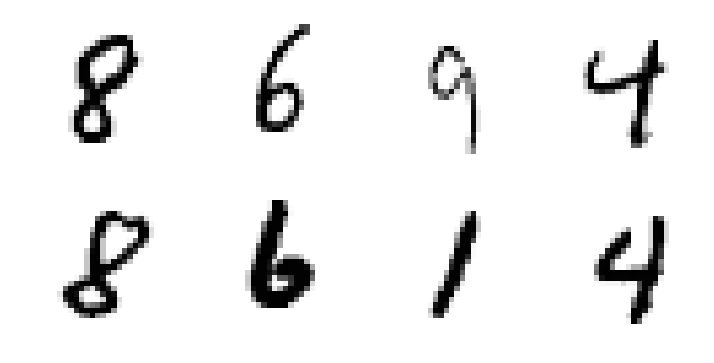

In [85]:
plot_gen_x(XT)

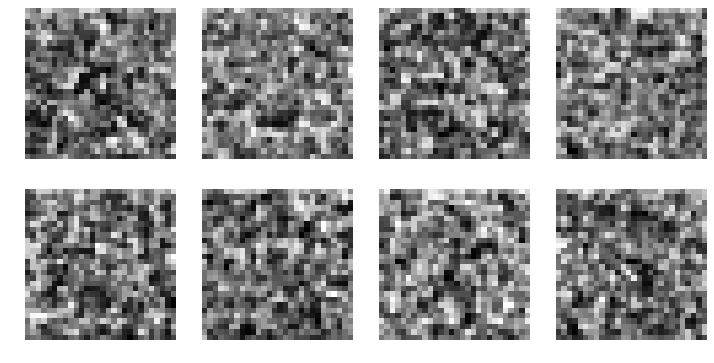

In [83]:
plot_gen_x(generated_images)

In [101]:
def plot_loss(losses):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g"], label='generative loss')
        plt.legend()
        plt.show()


In [ ]:
y_hat_idx = np.argmax(y_hat,axis=1)
y_idx = np.argmax(y,axis=1)
diff = y_idx-y_hat_idx
n_tot = y.shape[0]
n_rig = (diff==0).sum()
acc = n_rig*100.0/n_tot
print "Accuracy: %0.02f pct (%d of %d) right"%(acc, n_rig, n_tot)

In [100]:
losses = {"d":[], "g":[]}

In [108]:
def train_for_n(nb_epoch=5000, plt_frq=25,BATCH_SIZE=32):

    for e in tqdm(range(nb_epoch)):  
        print e
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=BATCH_SIZE),:,:,:]    
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        generated_images = generator.predict(noise_gen)
        
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*BATCH_SIZE,2])
        y[0:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        
        #make_trainable(discriminator,True)
        d_loss  = discriminator.train_on_batch(X,y)
        losses["d"].append(d_loss)
    
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        y2 = np.zeros([BATCH_SIZE,2])
        y2[:,1] = 1
        
        #make_trainable(discriminator,False)
        g_loss = GAN.train_on_batch(noise_tr, y2 )
        losses["g"].append(g_loss)
        
        # Updates plots
        if e%plt_frq==plt_frq-1:
            plot_loss(losses)
            plot_gen()

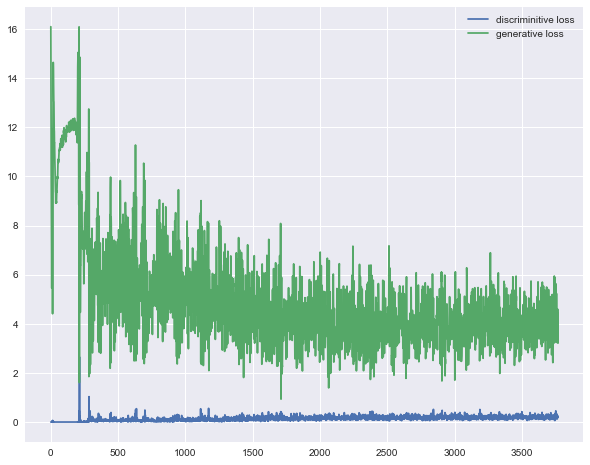

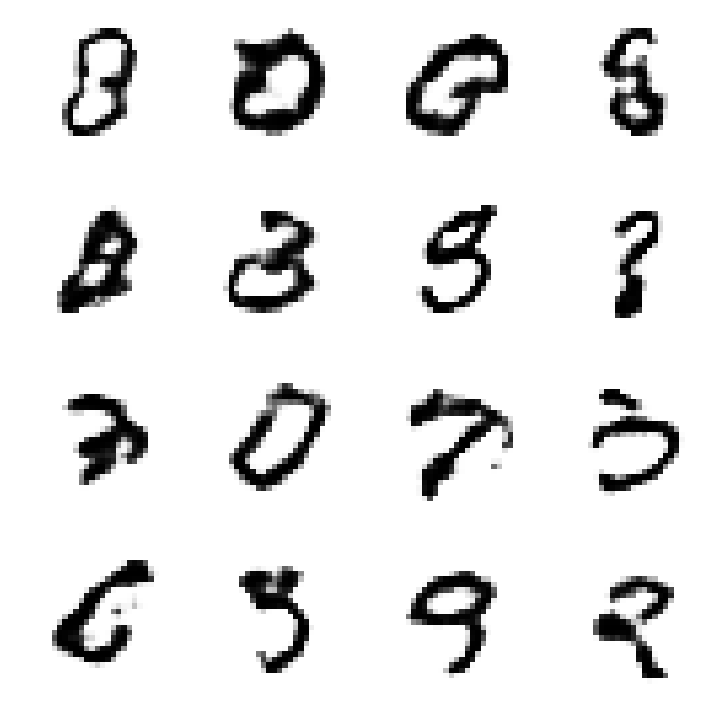




 61%|██████    | 3650/6000 [18:28:53<3:13:04,  4.93s/it]

3650





 61%|██████    | 3651/6000 [18:28:57<3:04:29,  4.71s/it]

3651





 61%|██████    | 3652/6000 [18:29:02<2:57:43,  4.54s/it]

3652


In [ ]:
train_for_n(nb_epoch=6000, plt_frq=25,BATCH_SIZE=32)
